In [1]:
import os
import sys
import time
import glob
import io
import pytesseract
from pytesseract import Output
from PIL import Image, ImageDraw
import cv2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None
import layoutparser

In [2]:
nb_dir = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src'
sys.path.append(nb_dir)
sys.path.append(os.path.split(nb_dir)[0])

import config
import src.utilities.app_context as app_context
from src.utilities.primalaynet.infer import draw_box
app_context.init()
app_context.application_context = dict({'task_id': 'BM-DUMMY'})

#path to craft model, weight can be pulled form the production bracnh of repo
config.CRAFT_MODEL_PATH = "/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_mlt_25k.pth"
config.CRAFT_REFINE_MODEL_PATH  = '/home/dhiraj/Documents/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/utilities/craft_pytorch/model/craft_refiner_CTW1500.pth' 


from src.services.main import generate_response,break_blocks,merge_vertically,merge_horizontally,extract_images_and_text_regions

Loading weights of refiner from checkpoint (./model/craft_refiner_CTW1500.pth)


In [3]:
import layoutparser as lp
model_primalaynet = lp.Detectron2LayoutModel('lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',label_map = {1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"},extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.5])


In [4]:
def draw_box(filepath,desired_width, desired_height,save_dir, df, color="green", save=False):
    image  = Image.open(filepath)
    image  = image.resize((desired_width, desired_height))
    draw   = ImageDraw.Draw(image)
    if type(df) is list:
        for i in df:
            for index, row in i.iterrows():
                left   = int(row['text_left'])
                right  = int(row['text_width'] + left)
                top    = int(row['text_top'])
                bottom = int(row["text_height"] + top)
                draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    else:

        for index, row in df.iterrows():
            left   = int(row['text_left'])
            right  = int(row['text_width'] + left)
            top    = int(row['text_top'])
            bottom = int(row["text_height"] + top)
            draw.rectangle(((left, top), (right,bottom)), outline=color,width=3)
    save_filepath = os.path.join(save_dir, os.path.basename(filepath))
    if save:
        image.save(save_filepath)
    
    return image

In [5]:
#dir which contains the pdf file
input_dir = '/home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/'
filename = '35871.pdf'
lang     = 'en'

In [6]:
[pdf_data,flags] = extract_images_and_text_regions(filename, input_dir,lang,page_layout='double_column')
[pdf_data,flags] = merge_horizontally([pdf_data,flags])
[pdf_data,flags] = merge_vertically([pdf_data,flags])
[pdf_data,flags] = break_blocks([pdf_data,flags])
#response        = generate_response([pdf_data,flags])

[2020-12-04 13:38:05,268] {loghandler.py:21} MainThread INFO in loghandler: document preprocessing started ===>
[2020-12-04 13:38:05,271] {loghandler.py:21} MainThread INFO in loghandler: created processing directories successfully /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/35871_d6490a60-3607-11eb-807f-add94cbcc44c
[2020-12-04 13:38:05,274] {loghandler.py:21} MainThread INFO in loghandler: filepath /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/35871.pdf, working_dir /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/35871_d6490a60-3607-11eb-807f-add94cbcc44c
[2020-12-04 13:38:07,320] {loghandler.py:21} MainThread INFO in loghandler: Extracting xml of /home/dhiraj/Documents/Anuwad/anuvaad/anuvaad-etl/anuvaad-extractor/block-merger/src/notebooks/sample-data/input/35871.pdf
[2020-12-04 13:38:

In [7]:
# width_ratio = pdf_data['page_width'] / pdf_data['pdf_image_width']
# height_ratio = pdf_data['page_height'] / pdf_data['pdf_image_height']
# predict_primanet(img_filepath,pdf_bg_img_filepaths,to_check[0],width_ratio,height_ratio)

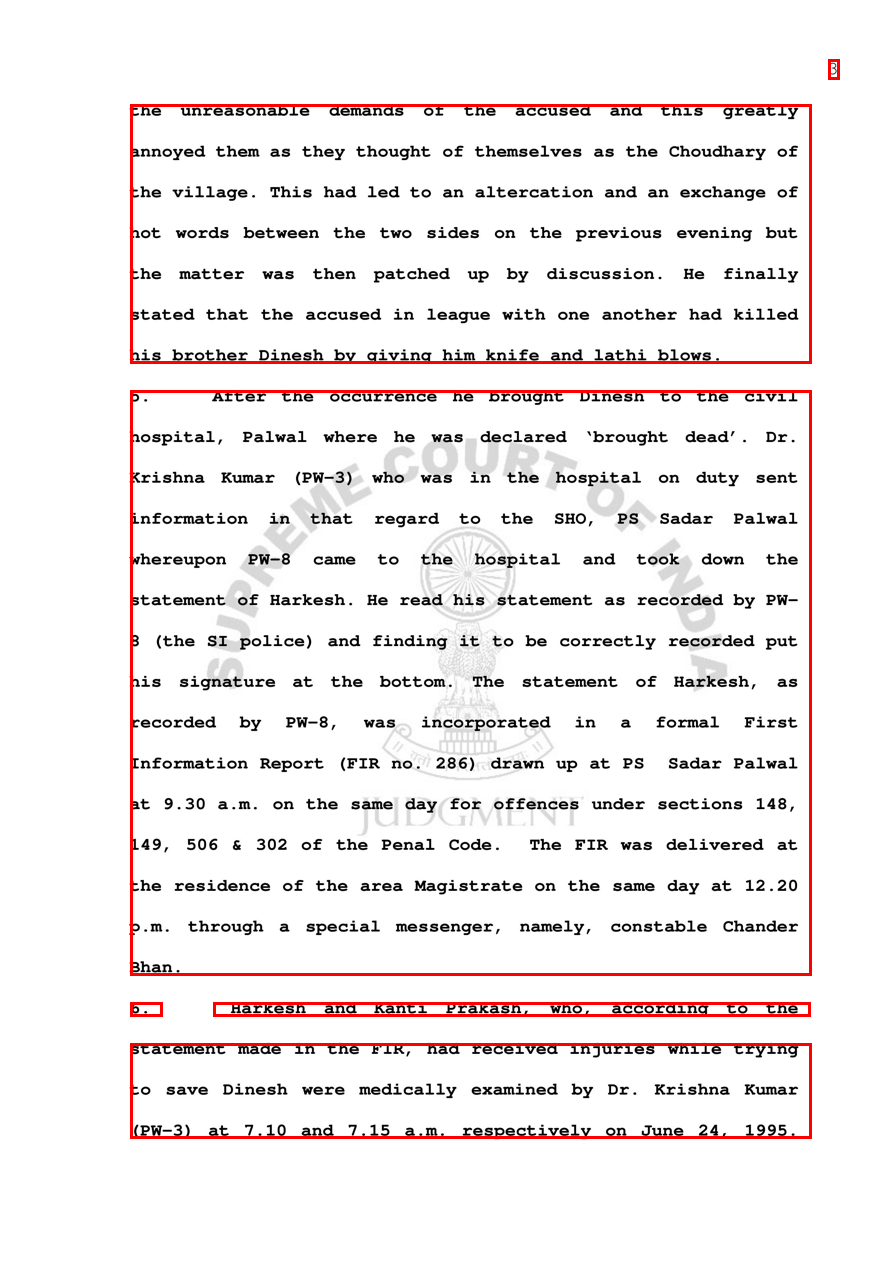

In [8]:
page_index = 2
to_check        = pdf_data['p_dfs']
#to_check_in_df        = pdf_data['v_dfs'][page_index]
img_filepath    = pdf_data['pdf_image_paths'][page_index]
pdf_bg_img_filepaths  = pdf_data['pdf_bg_img_filepaths'][page_index]
df              = to_check[page_index]

desired_width, desired_height = pdf_data['page_width'] , pdf_data['page_height']
draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)

In [9]:
df

,xml_index,text_top,text_left,text_width,text_height,text,font_size,font_family,font_color,attrib,font_family_updated,font_size_updated,children
0,0,59,828,11,20,3,18,BAAAAA+CourierNewPSMT,#000000,,CourierNewPSMT,18,None
1,1,104,130,681,14,the unreasonable demands of the accu...,18,Courier,#000000,BOLD,Courier,18,None
2,2,145,130,681,14,annoyed them as they thought of themselves as ...,18,Courier,#000000,BOLD,Courier,18,None
3,3,186,130,681,14,the village. This had led to an altercation an...,18,Courier,#000000,BOLD,Courier,18,None
4,4,227,130,681,14,hot words between the two sides on...,18,Courier,#000000,BOLD,Courier,18,None
5,5,268,130,681,14,the matter was then patched up by ...,18,Courier,#000000,BOLD,Courier,18,None
6,6,308,130,681,14,stated that the accused in league with one ano...,18,Courier,#000000,BOLD,Courier,18,None
7,7,349,130,605,14,his brother Dinesh by giving him knife and lat...,18,Courier,#000000,BOLD,Courier,18,None
8,8,390,130,680,14,5. After the occurrence he brought ...,18,Courier,#000000,None,Courier,18,"{""index"":{""0"":0,""1"":1},""xml_index"":{""0"":8,""1"":..."
9,10,431,130,681,14,"hospital, Palwal where he was declar...",18,Courier,#000000,BOLD,Courier,18,None


In [20]:
for i in to_check_in_df['children']:
    d =pd.read_json(i)
    print(d)
    print(d['children'])

   xml_index  text_top  text_left  text_width  text_height         text  \
0        NaN       751        122         311           12                
1        NaN       767        105         328           13                
2        NaN       784        107         326           13                
3        NaN       799        105         328           14                
4        NaN       813        107         326           17                
5        NaN       830        107         326           17                
6        NaN       849        105         328           14                
7        NaN       865        107         326           14                
8        NaN       882        107         261           15                

   font_size       font_family  font_color  attrib font_family_updated  \
0         13  Arial Unicode MS         NaN     NaN    Arial Unicode MS   
1         12  Arial Unicode MS         NaN     NaN    Arial Unicode MS   
2         11  Arial Unicode

   xml_index    text_top   text_left  text_width  text_height text  font_size  \
0        NaN  318.270917  693.232527   88.697503    66.002374       66.002374   

        font_family  font_color  attrib font_family_updated  font_size_updated  
0  Arial Unicode MS         NaN     NaN    Arial Unicode MS          66.002374  


KeyError: 'children'

In [ ]:
import numpy as np
p_df_image = draw_box(img_filepath,desired_width, desired_height, 'path',df, color="red", save=False)
sc_pdf_image = draw_box(img_filepath,desired_width, desired_height, 'path',to_check_in_df, color="red", save=False)
stiched_imag = np.hstack([np.array(p_df_image) ,np.array(sc_pdf_image)])
compare_image = Image.fromarray(stiched_imag)
compare_image.save("/home/naresh/1.jpg")

In [ ]:
def predict_primanet(image_path,bg_image_path,in_df,width_ratio,height_ratio):
    image1  = cv2.imread(image_path)
    image2  = cv2.imread(bg_image_path)
    image = image1[..., ::-1] 
    layout = model_primalaynet.detect(image)
    boxes,coords = draw_box(layout, in_df,width_ratio,height_ratio)
    final_coord= []
    for coord in coords:
        temp_dict={}
        temp_dict['text_left']=coord[0]; temp_dict['text_top']=coord[1]
        temp_dict['text_width']=coord[2]; temp_dict['text_height']=coord[3]
        #draw.rectangle(coord, width=3,outline='red')
        final_coord.append(temp_dict)
        cv2.rectangle(image1, (int(coord[0]),int(coord[1])), (int(coord[2]),int(coord[3])),(255,255,0),3)
        cv2.rectangle(image2, (int(coord[0]*width_ratio),int(coord[1]*height_ratio)), (int(coord[2]*width_ratio),int(coord[3]*height_ratio)),(255,255,0),3)

        cv2.imwrite("1.jpg",image1)
        cv2.imwrite("2.jpg",image2)

    return final_coord